In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from collections import deque
import random
import pandas as pd
import os
import json
import matplotlib.pyplot as plt


In [ ]:
class RecommendationEnv:
    """Environment for recommendation system using reinforcement learning"""

    def __init__(self, user_data, item_data, interaction_data, n_items_to_recommend=5):
        """
        Initialize the recommendation environment

        Args:
            user_data: DataFrame with user features
            item_data: DataFrame with item features
            interaction_data: DataFrame with user-item interactions
            n_items_to_recommend: Number of items to recommend in each step
        """
        self.user_data = user_data
        self.item_data = item_data
        self.interaction_data = interaction_data
        self.n_items = len(item_data)
        self.n_users = len(user_data)
        self.n_items_to_recommend = n_items_to_recommend

        # Create user sessions from interaction data
        self._create_user_sessions()

        # Current state variables
        self.current_user_id = None
        self.current_session = None
        self.current_step = 0
        self.done = False
        self.recommended_items = set()
        self.recommended_categories = set()
        self.last_recommendation_correct = False

    def _create_user_sessions(self):
        """Create user sessions from interaction data"""
        self.user_sessions = {}

        # Group interactions by user
        grouped = self.interaction_data.groupby('user_id')

        for user_id, group in grouped:
            # Sort by timestamp
            sorted_interactions = group.sort_values('timestamp')
            self.user_sessions[user_id] = sorted_interactions

    def get_state_size(self):
        """Return the size of the state representation"""
        # User features + context features + historical interaction features
        return len(self.user_data.columns) - 1 + 5 + 10

    def get_action_size(self):
        """Return the size of the action space (number of items)"""
        return self.n_items

    def reset(self, user_id=None):
        """
        Reset the environment for a new user session

        Args:
            user_id: Optional specific user to start with, otherwise random

        Returns:
            state: Initial state representation
        """
        if not self.user_sessions:
            raise ValueError("No user sessions available.")

        if user_id is None or user_id not in self.user_sessions:
            # Randomly select a user from those with sessions
            user_id = random.choice(list(self.user_sessions.keys()))

        self.current_user_id = user_id
        self.current_session = self.user_sessions[user_id].copy()
        self.current_step = 0
        self.done = False
        self.recommended_items = set()
        self.recommended_categories = set()
        self.last_recommendation_correct = False

        # Return initial state
        return self._get_state_representation()

    def step(self, action):
        """
        Take a step in the environment by recommending an item

        Args:
            action: Item ID to recommend

        Returns:
            next_state: Next state representation
            reward: Reward obtained
            done: Whether the session is over
            info: Additional information
        """
        reward = 0
        info = {}

        # Convert action index to item_id
        item_id = action

        # Add to recommended items
        self.recommended_items.add(item_id)

        # Check if the recommended item matches the actual interaction
        if self.current_step < len(self.current_session):
            actual_item = self.current_session.iloc[self.current_step]['item_id']
            interaction_type = self.current_session.iloc[self.current_step]['interaction_type']

            # Get category information if available
            item_category = self.item_data[self.item_data['item_id'] == item_id]['category'].values[0] \
                if item_id in self.item_data['item_id'].values else None
            actual_category = self.item_data[self.item_data['item_id'] == actual_item]['category'].values[0] \
                if actual_item in self.item_data['item_id'].values else None

            # Calculate reward based on the interaction type and whether the recommendation was correct
            if item_id == actual_item:
                if interaction_type == 'click':
                    reward = 1
                elif interaction_type == 'like':
                    reward = 2
                elif interaction_type == 'purchase':
                    reward = 5
                elif interaction_type == 'share':
                    reward = 3

                # Add bonus for sequential correct recommendations
                if self.current_step > 0 and self.last_recommendation_correct:
                    reward += 0.5  # Bonus for consecutive good recommendations

                self.last_recommendation_correct = True

            elif item_category and actual_category:
                # Category similarity rewards
                if item_category == actual_category:
                    reward = 0.1

                self.last_recommendation_correct = False
            else:
                # Progressive negative rewards to discourage repeated mistakes
                if hasattr(self, 'mistake_counter'):
                    self.mistake_counter += 1
                    reward = -0.1 * min(self.mistake_counter, 3)  # Cap at -0.3
                else:
                    self.mistake_counter = 1
                    reward = -0.1

                self.last_recommendation_correct = False

        # Reset mistake counter on good recommendations
        if reward > 0:
            self.mistake_counter = 0

        # Add diversity bonus if recommending different categories
        if len(self.recommended_categories) > 0 and item_category not in self.recommended_categories:
            reward += 0.2  # Bonus for diverse recommendations

        if item_category:
            self.recommended_categories.add(item_category)

        # Move to next step
        self.current_step += 1

        # Check if session is over (based on max steps or end of interactions)
        if self.current_step >= len(self.current_session) or self.current_step >= 20:
            self.done = True

        # Get next state
        next_state = self._get_state_representation()

        info = {
            'user_id': self.current_user_id,
            'item_id': item_id,
            'step': self.current_step
        }

        return next_state, reward, self.done, info

    def _get_state_representation(self):
        """
        Create a state representation based on the current user and context

        Returns:
            state: A vector representing the current state
        """
        # User features
        user_features = self.user_data[self.user_data['user_id'] == self.current_user_id].iloc[0].drop('user_id').values

        # Context features (time of day, day of week)
        if self.current_step < len(self.current_session):
            timestamp = self.current_session.iloc[self.current_step]['timestamp']
            # Extract time features
            hour = timestamp.hour / 24.0
            day_of_week = timestamp.dayofweek / 6.0
            context_features = np.array([hour, day_of_week, 0, 0, 0])  # Placeholder for more context features
        else:
            context_features = np.zeros(5)

        # Historical interaction features
        if self.current_step > 0:
            # Get the last few interactions
            recent_interactions = self.current_session.iloc[:self.current_step]

            # Create historical features (categories of recently interacted items)
            # Placeholder
            hist_features = np.zeros(10)

            # Count categories of recently interacted items
            for _, row in recent_interactions.iterrows():
                item_id = row['item_id']
                if item_id in self.item_data['item_id'].values:
                    item_idx = self.item_data[self.item_data['item_id'] == item_id].index[0]
                    category = self.item_data.iloc[item_idx, 1]
                    hist_features[category % 10] += 1
        else:
            hist_features = np.zeros(10)

        # Combine all features
        state = np.concatenate([user_features, context_features, hist_features])
        return state


In [ ]:
class DQNRecommender:
    """DQN-based recommendation system"""

    def __init__(self, state_size, action_size, learning_rate=0.001, gamma=0.95,
                 epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995, memory_size=10000):
        """
        Initialize the DQN recommender

        Args:
            state_size: Size of the state representation
            action_size: Size of the action space (number of items)
            learning_rate: Learning rate for the model
            gamma: Discount factor
            epsilon: Initial exploration rate
            epsilon_min: Minimum exploration rate
            epsilon_decay: Decay rate for exploration
            memory_size: Size of the replay memory
        """
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=memory_size)
        self.gamma = gamma  # Discount factor
        self.epsilon = epsilon  # Exploration rate
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.learning_rate = learning_rate
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()
        self.batch_size = 32

    def _build_model(self):
        """Build a neural network model for deep Q-learning"""
        model = Sequential()
        model.add(Input(shape=(self.state_size,)))
        model.add(BatchNormalization())
        model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dropout(0.2))
        model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dropout(0.2))  # Prevent overfitting
        model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dropout(0.1))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss=Huber(), optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def update_target_model(self):
        """Update the target model with weights from the main model"""
        self.target_model.set_weights(self.model.get_weights())

    def remember(self, state, action, reward, next_state, done):
        """Store experience with priority based on TD error"""
        # Calculate TD error for prioritization
        q_values = self.model.predict(state.reshape(1, -1), verbose=0)[0]
        next_q_values = self.target_model.predict(next_state.reshape(1, -1), verbose=0)[0]

        if done:
            target = reward
        else:
            target = reward + self.gamma * np.amax(next_q_values)

        td_error = abs(target - q_values[action])

        # Store with priority
        self.memory.append((state, action, reward, next_state, done, td_error))

    def act(self, state, recommended_items=None):
        """
        Choose an action using epsilon-greedy policy

        Args:
            state: Current state representation
            recommended_items: Set of already recommended items to avoid

        Returns:
            action: Chosen action (item ID)
        """
        if recommended_items is None:
            recommended_items = set()

        if np.random.rand() <= self.epsilon:
            # Explore: choose a random action not in recommended_items
            valid_actions = [a for a in range(self.action_size) if a not in recommended_items]
            if not valid_actions:  # If all items have been recommended, pick any
                return np.random.randint(self.action_size)
            return np.random.choice(valid_actions)

        # Exploit: choose the best action based on Q-values
        q_values = self.model.predict(state.reshape(1, -1), verbose=0)[0]

        # Normalize Q-values to prevent dominance of extreme values
        q_values = q_values / (np.max(np.abs(q_values)) + 1e-6)  # Avoid division by zero

        # Mask out already recommended items with very low values
        for item in recommended_items:
            if item < len(q_values):
                q_values[item] *= 0.1

        return np.argmax(q_values)

    def replay(self, batch_size):
        """Train the model on a batch of experiences"""
        batch_size = batch_size or self.batch_size

        if len(self.memory) < batch_size:
            return

        minibatch = random.sample(self.memory, batch_size)

        states = np.zeros((batch_size, self.state_size))
        next_states = np.zeros((batch_size, self.state_size))

        for i, (state, action, reward, next_state, done, _) in enumerate(minibatch):
            states[i] = state
            next_states[i] = next_state

        # Double DQN: Use main network to select actions, target network to evaluate them
        current_q_values = self.model.predict(states, verbose=0)
        next_q_values_main = self.model.predict(next_states, verbose=0)
        next_q_values_target = self.target_model.predict(next_states, verbose=0)

        # Update Q-values for the actions taken
        for i, (state, action, reward, next_state, done, _) in enumerate(minibatch):
            if done:
                target = reward
            else:
                # Select action using main network
                best_action = np.argmax(next_q_values_main[i])
                # Evaluate using target network
                target = reward + self.gamma * next_q_values_target[i][best_action]

            current_q_values[i][action] = target

        # Train the model
        self.model.fit(states, current_q_values, epochs=1, verbose=0, batch_size=min(32, batch_size))

        # Decay epsilon
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

    def load(self, name):
        """Load model weights"""
        self.model.load_weights(name)

    def save(self, name):
        """Save model weights"""
        self.model.save_weights(name)


In [ ]:
# Function to train the DQN recommender
def train_dqn_recommender(env, dqn_agent, n_episodes=1000, max_steps=20, batch_size=32,
                          target_update_freq=10, checkpoint_freq=100, checkpoint_dir='checkpoints'):
    """
    Train the DQN recommender

    Args:
        env: Recommendation environment
        dqn_agent: DQN recommender agent
        n_episodes: Number of episodes to train
        max_steps: Maximum steps per episode
        batch_size: Batch size for replay
        target_update_freq: Frequency of target network updates
        checkpoint_freq: Frequency of saving checkpoints
        checkpoint_dir: Directory to save checkpoints

    Returns:
        history: Training history
    """
    # Create checkpoint directory if it doesn't exist
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    # Training history
    history = {
        'episode_rewards': [],
        'episode_lengths': [],
        'epsilon_values': []
    }

    for episode in range(n_episodes):
        # Reset environment for a new episode
        state = env.reset()
        total_reward = 0
        recommended_items = set()

        for step in range(max_steps):
            # Choose action
            action = dqn_agent.act(state, recommended_items)

            # Take action
            next_state, reward, done, info = env.step(action)

            # Add to recommended items
            recommended_items.add(action)

            # Remember experience
            dqn_agent.remember(state, action, reward, next_state, done)

            # Update state and reward
            state = next_state
            total_reward += reward

            # Train the agent
            if len(dqn_agent.memory) > batch_size:
                dqn_agent.replay(batch_size)

            if done:
                break

        # Update target model periodically
        if episode % target_update_freq == 0:
            dqn_agent.update_target_model()

        # Save checkpoint periodically
        if episode % checkpoint_freq == 0:
            checkpoint_path = os.path.join(checkpoint_dir, f'dqn_recommender_ep{episode}.weights.h5')
            dqn_agent.save(checkpoint_path)

            # Save training history
            history_path = os.path.join(checkpoint_dir, 'training_history.json')
            with open(history_path, 'w') as f:
                json.dump(history, f)

        # Track statistics
        history['episode_rewards'].append(total_reward)
        history['episode_lengths'].append(step + 1)
        history['epsilon_values'].append(dqn_agent.epsilon)

        # Print progress
        if episode % 10 == 0:
            print(f"Episode: {episode}/{n_episodes}, Reward: {total_reward:.2f}, "
                  f"Steps: {step+1}, Epsilon: {dqn_agent.epsilon:.4f}")

    return history


In [ ]:
# Function to evaluate the trained recommender
def evaluate_recommender(env, dqn_agent, n_episodes=100):
    """
    Evaluate the trained DQN recommender

    Args:
        env: Recommendation environment
        dqn_agent: Trained DQN recommender agent
        n_episodes: Number of episodes for evaluation

    Returns:
        metrics: Evaluation metrics
    """
    total_rewards = []
    hit_rates = []

    for episode in range(n_episodes):
        state = env.reset()
        total_reward = 0
        hits = 0
        steps = 0
        recommended_items = set()

        done = False
        while not done:
            # Choose action (no exploration)
            action = dqn_agent.act(state, recommended_items)

            # Take action
            next_state, reward, done, info = env.step(action)

            # Add to recommended items
            recommended_items.add(action)

            # Update metrics
            total_reward += reward
            steps += 1

            # Check if it was a hit (reward > 0.1)
            if reward > 0.1:
                hits += 1

            state = next_state

        # Calculate hit rate
        hit_rate = hits / steps if steps > 0 else 0

        total_rewards.append(total_reward)
        hit_rates.append(hit_rate)

    # Calculate aggregate metrics
    metrics = {
        'avg_reward': np.mean(total_rewards),
        'avg_hit_rate': np.mean(hit_rates)
    }

    return metrics

In [ ]:
# Function to generate synthetic data for testing
def generate_synthetic_data(n_users=1000, n_items=500, n_interactions=10000):
    """Generate synthetic data for testing the recommendation system"""

    # Create user data
    user_features = ['age', 'gender', 'country', 'membership_level']
    user_data = pd.DataFrame({
        'user_id': range(n_users),
        'age': np.random.randint(18, 70, n_users),
        'gender': np.random.randint(0, 2, n_users),
        'country': np.random.randint(0, 10, n_users),
        'membership_level': np.random.randint(0, 4, n_users)
    })

    # Create item data
    item_data = pd.DataFrame({
        'item_id': range(n_items),
        'category': np.random.randint(0, 20, n_items),
        'price_level': np.random.randint(1, 5, n_items),
        'popularity': np.random.rand(n_items),
        'release_recency': np.random.randint(0, 100, n_items)
    })

    # Create interaction data
    interaction_types = ['click', 'like', 'purchase', 'share']
    interaction_weights = [0.7, 0.2, 0.05, 0.05]  # Probabilities for each type

    # Generate timestamps over the last 30 days
    end_date = pd.Timestamp.now()
    start_date = end_date - pd.Timedelta(days=30)
    timestamps = [start_date + pd.Timedelta(seconds=np.random.randint(0, 30*24*3600)) for _ in range(n_interactions)]

    interaction_data = pd.DataFrame({
        'user_id': np.random.choice(user_data['user_id'], n_interactions),
        'item_id': np.random.choice(item_data['item_id'], n_interactions),
        'interaction_type': np.random.choice(interaction_types, n_interactions, p=interaction_weights),
        'timestamp': timestamps
    })

    # Sort by timestamp
    interaction_data = interaction_data.sort_values('timestamp')

    return user_data, item_data, interaction_data


In [ ]:
def plot_training_metrics(history):
    """Plot training metrics from history"""
    plt.figure(figsize=(12, 5))

    # Plot Episode Rewards
    plt.subplot(1, 3, 1)
    plt.plot(history['episode_rewards'], label="Total Reward")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title("Reward Progression")
    plt.legend()

    # Plot Steps per Episode
    plt.subplot(1, 3, 2)
    plt.plot(history['episode_lengths'], label="Steps per Episode", color="orange")
    plt.xlabel("Episode")
    plt.ylabel("Steps Taken")
    plt.title("Steps Progression")
    plt.legend()

    # Plot Epsilon Decay
    plt.subplot(1, 3, 3)
    plt.plot(history['epsilon_values'], label="Epsilon", color="red")
    plt.xlabel("Episode")
    plt.ylabel("Epsilon")
    plt.title("Epsilon Decay")
    plt.legend()

    plt.tight_layout()
    plt.show()

Training DQN recommender...
Episode: 0/500, Reward: 1.20, Steps: 8, Epsilon: 1.0000
Episode: 10/500, Reward: 1.40, Steps: 12, Epsilon: 0.9231
Episode: 20/500, Reward: 1.50, Steps: 9, Epsilon: 0.8269
Episode: 30/500, Reward: 0.20, Steps: 8, Epsilon: 0.7572
Episode: 40/500, Reward: 2.80, Steps: 13, Epsilon: 0.6803
Episode: 50/500, Reward: 2.20, Steps: 16, Epsilon: 0.6082
Episode: 60/500, Reward: 1.10, Steps: 7, Epsilon: 0.5492
Episode: 70/500, Reward: 2.30, Steps: 14, Epsilon: 0.4944
Episode: 80/500, Reward: 2.20, Steps: 14, Epsilon: 0.4487
Episode: 90/500, Reward: 1.10, Steps: 10, Epsilon: 0.4052
Episode: 100/500, Reward: 1.10, Steps: 7, Epsilon: 0.3748
Episode: 110/500, Reward: 1.10, Steps: 9, Epsilon: 0.3442
Episode: 120/500, Reward: 1.00, Steps: 7, Epsilon: 0.3127
Episode: 130/500, Reward: 1.70, Steps: 11, Epsilon: 0.2840
Episode: 140/500, Reward: 1.40, Steps: 12, Epsilon: 0.2575
Episode: 150/500, Reward: 2.10, Steps: 14, Epsilon: 0.2330
Episode: 160/500, Reward: 1.20, Steps: 8, Epsi

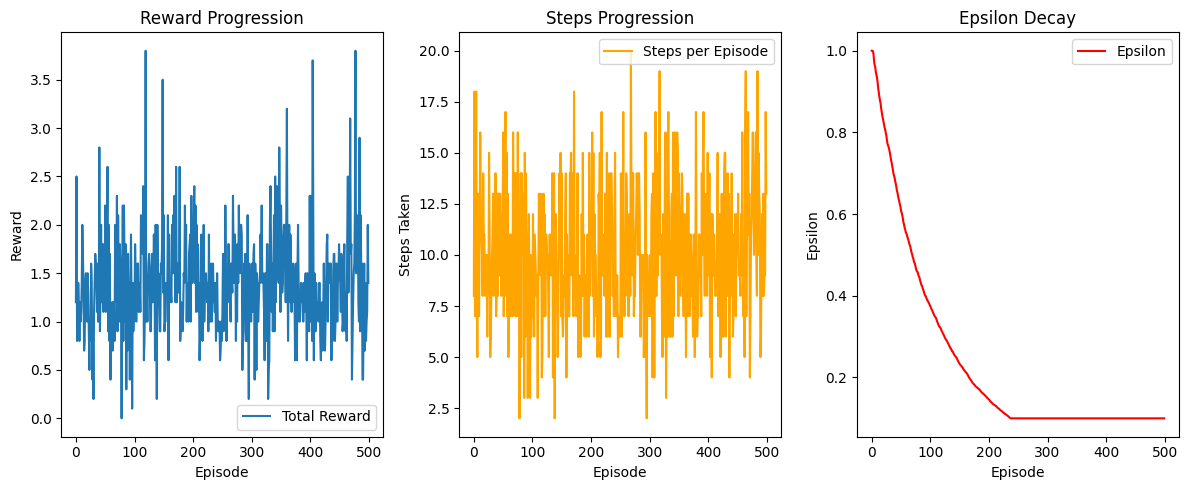

Evaluating DQN recommender...
Evaluation metrics:
Average reward: 0.9420
Average hit rate: 0.4707


In [ ]:
# Main function
def main():
    # Generate synthetic data
    user_data, item_data, interaction_data = generate_synthetic_data()

    # Create environment
    env = RecommendationEnv(user_data, item_data, interaction_data)

    # Get state and action sizes
    state_size = env.get_state_size()
    action_size = env.get_action_size()

    # Create DQN agent
    dqn_agent = DQNRecommender(
        state_size=state_size,
        action_size=action_size,
        learning_rate=0.0005,
        gamma=0.9,
        epsilon=1.0,
        epsilon_min=0.1,
        epsilon_decay=0.999
    )

    # Train the agent
    print("Training DQN recommender...")
    history = train_dqn_recommender(
        env=env,
        dqn_agent=dqn_agent,
        n_episodes=500,
        batch_size=32,
        target_update_freq=10,
        checkpoint_freq=100,
        checkpoint_dir='dqn_checkpoints'
    )

    # Plot training performance
    plot_training_metrics(history)

    # Save the final model
    dqn_agent.save('dqn_recommender_final.weights.h5')

    # Evaluate the trained model
    print("Evaluating DQN recommender...")
    metrics = evaluate_recommender(env, dqn_agent, n_episodes=100)

    print("Evaluation metrics:")
    print(f"Average reward: {metrics['avg_reward']:.4f}")
    print(f"Average hit rate: {metrics['avg_hit_rate']:.4f}")

    return dqn_agent, env, history, metrics


if __name__ == "__main__":
    main()